In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.4 MB/s eta 0:00:00


# LSTM Model with GloVe Embeddings
## Drug Reviews Classification - Gershom

**Model**: LSTM (Long Short-Term Memory) / BiLSTM
**Embedding**: GloVe (200-dim, medium config)
**Task**: Drug review rating prediction

---

### Notebook Structure:
1. Setup and Data Loading
2. GloVe Embedding Training
3. LSTM Model Architecture
4. Training & Evaluation
5. Results Analysis

## 1. Setup and Imports

In [ ]:
# Standard libraries
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, Embedding,
    Input, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Shared modules
from src.data_utils import DataLoader, create_dataset_from_dataframe
from src.preprocessing_pipeline import get_preprocessor, TextPreprocessor
from embeddings.glove_embedding import GloVeEmbedding, get_glove_embedding

print("✓ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

✓ All imports successful!
TensorFlow version: 2.19.0
GPU Available: []


## 2. Configuration

In [ ]:
# Paths
TRAIN_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_train.csv'
VAL_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_validation.csv'
TEST_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_test.csv'

# Data columns
TEXT_COLUMN = 'review'
LABEL_COLUMN = 'rating'

# Preprocessing
PREPROCESSING_CONFIG = 'moderate'  # minimal, moderate, or aggressive

# Embedding configuration
EMBEDDING_TYPE = 'glove'
EMBEDDING_CONFIG = 'medium'  # 200-dim, 15 iterations
EMBEDDING_DIM = 200

# Model architecture (OPTIMIZED FOR SPEED)
USE_BIDIRECTIONAL = False  # Set to True for BiLSTM, False for LSTM
LSTM_UNITS = 64  # Reduced from 128 → 64 for faster training
DROPOUT_RATE = 0.3
RECURRENT_DROPOUT = 0.2
DENSE_UNITS = 64

# Training (OPTIMIZED FOR SPEED)
BATCH_SIZE = 128   # Increased from 32 → 64 for faster training
EPOCHS = 15
LEARNING_RATE = 0.001
PATIENCE = 3

# Sequence parameters (OPTIMIZED FOR SPEED)
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = 10000  # Maximum vocabulary size

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Configuration set! (OPTIMIZED FOR SPEED)")
print(f"Model type: {'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM'}")
print(f"Embedding: {EMBEDDING_TYPE} ({EMBEDDING_CONFIG})")
print(f"LSTM units: {LSTM_UNITS}")
print(f"Batch size: {BATCH_SIZE} (larger = faster)")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")

Configuration set! (OPTIMIZED FOR SPEED)
Model type: LSTM
Embedding: glove (medium)
LSTM units: 64
Batch size: 128 (larger = faster)
Max sequence length: 100


## 3. Load and Preprocess Data

In [ ]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nClass distribution (train):")
print(train_df[LABEL_COLUMN].value_counts().sort_index())

Loading datasets...
Train size: 110811
Validation size: 27703
Test size: 46108

Columns: ['Unnamed: 0', 'patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length']

Class distribution (train):
rating
1.0     14286
2.0      4776
3.0      4540
4.0      3501
5.0      5711
6.0      4359
7.0      6671
8.0     13305
9.0     19407
10.0    34255
Name: count, dtype: int64


In [ ]:
# Download required NLTK data
import nltk
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)  # Open Multilingual WordNet
print("✓ NLTK data downloaded successfully!")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✓ NLTK data downloaded successfully!


In [ ]:
# Initialize preprocessor
preprocessor = get_preprocessor(PREPROCESSING_CONFIG)
print(f"Using '{PREPROCESSING_CONFIG}' preprocessing configuration")

# Get tokenized texts (GloVe needs tokens, not strings)
print("\nPreprocessing and tokenizing...")
train_texts = train_df[TEXT_COLUMN].fillna('').tolist()
val_texts = val_df[TEXT_COLUMN].fillna('').tolist()
test_texts = test_df[TEXT_COLUMN].fillna('').tolist()

# Get tokenized versions for GloVe training
train_tokens = preprocessor.get_tokens_batch(train_texts)
val_tokens = preprocessor.get_tokens_batch(val_texts)
test_tokens = preprocessor.get_tokens_batch(test_texts)

# Extract labels
train_labels = train_df[LABEL_COLUMN].values
val_labels = val_df[LABEL_COLUMN].values
test_labels = test_df[LABEL_COLUMN].values

print(f"✓ Tokenization complete!")
print(f"Example tokenized review: {train_tokens[0][:20]}...")  # First 20 tokens

Using 'moderate' preprocessing configuration

Preprocessing and tokenizing...
✓ Tokenization complete!
Example tokenized review: ['``', 'used', 'restasis', 'year', 'seen', 'almost', 'progress', '.', 'life', "'ve", 'red', 'bothersome', 'eyes', '.', 'trying', 'various', 'eye', 'drops', ',', 'doctor']...


## 4. Train GloVe Embeddings

In [15]:
# Initialize and train GloVe
print("Training GloVe embeddings...")
glove_model = get_glove_embedding(EMBEDDING_CONFIG)
glove_model.fit(train_tokens)

print("\n✓ GloVe training complete!")
print(f"Model info: {glove_model.get_model_info()}")
print(f"Vocabulary size: {glove_model.get_vocabulary_size()}")
print(f"Embedding dimension: {glove_model.embedding_dim}")

Training GloVe embeddings...

✓ GloVe training complete!
Model info: {'type': 'GloVe', 'embedding_dim': 200, 'vocab_size': 41432, 'native': False}
Vocabulary size: 41432
Embedding dimension: 200


In [ ]:
# Test GloVe embeddings with sample words
print("\nTesting GloVe embeddings...")
test_words = ['pain', 'drug', 'effective', 'side', 'effect']

for word in test_words:
    try:
        similar = glove_model.most_similar(word, topn=5)
        print(f"\n'{word}' most similar:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.3f}")
    except KeyError:
        print(f"\n'{word}' not in vocabulary")


Testing GloVe embeddings...

'pain' most similar:
  propoxy: 0.671
  fibromalgia: 0.660
  pudendal: 0.648
  hip.: 0.647
  pallodan: 0.647

'drug' most similar:
  medication: 0.726
  medicine: 0.668
  med: 0.619
  drugs: 0.612
  linziess: 0.586

'effective' most similar:
  pregnancy.: 0.556
  effiencient: 0.551
  100.25: 0.551
  goes-great: 0.549
  zyprexa-: 0.544

'side' most similar:
  effects: 0.693
  yet.: 0.664
  incurring: 0.650
  quesiness: 0.643
  dys: 0.633

'effect' most similar:
  effects: 0.771
  affects: 0.629
  affect: 0.600
  brochure.: 0.585
  anorgasma: 0.570


## 5. Create Sequences and Embedding Matrix

In [ ]:
# Build vocabulary from GloVe
vocab = glove_model.get_vocab()
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab[:VOCAB_SIZE-1])}  # Reserve 0 for padding
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = len(word_to_idx)

print(f"Vocabulary size (with special tokens): {len(word_to_idx)}")

# Convert tokens to sequences
def tokens_to_sequences(token_lists, word_to_idx):
    sequences = []
    for tokens in token_lists:
        seq = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
        sequences.append(seq)
    return sequences

train_sequences = tokens_to_sequences(train_tokens, word_to_idx)
val_sequences = tokens_to_sequences(val_tokens, word_to_idx)
test_sequences = tokens_to_sequences(test_tokens, word_to_idx)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\nSequence shapes:")
print(f"Train: {train_padded.shape}")
print(f"Val: {val_padded.shape}")
print(f"Test: {test_padded.shape}")

Vocabulary size (with special tokens): 10001

Sequence shapes:
Train: (110811, 100)
Val: (27703, 100)
Test: (46108, 100)


In [ ]:
# Create embedding matrix from GloVe
print("\nCreating embedding matrix...")
embedding_matrix = np.zeros((len(word_to_idx), EMBEDDING_DIM))

for word, idx in word_to_idx.items():
    if word not in ['<PAD>', '<UNK>']:
        try:
            embedding_matrix[idx] = glove_model.get_word_vector(word)
        except KeyError:
            # Initialize with small random values
            embedding_matrix[idx] = np.random.randn(EMBEDDING_DIM) * 0.01

print(f"✓ Embedding matrix shape: {embedding_matrix.shape}")
print(f"Non-zero rows: {np.count_nonzero(embedding_matrix.any(axis=1))}")


Creating embedding matrix...
✓ Embedding matrix shape: (10001, 200)
Non-zero rows: 9999


## 6. Process Labels for Classification

In [ ]:
# Check the rating distribution to decide on classification strategy
print("Rating distribution:")
print(train_df[LABEL_COLUMN].value_counts().sort_index())

# For this example, let's use binary classification: ratings >= 6 = positive (1), < 6 = negative (0)
CLASSIFICATION_TYPE = 'binary'  # 'binary', 'multiclass', or 'regression'
THRESHOLD = 6  # For binary classification

if CLASSIFICATION_TYPE == 'binary':
    train_y = (train_labels >= THRESHOLD).astype(int)
    val_y = (val_labels >= THRESHOLD).astype(int)
    test_y = (test_labels >= THRESHOLD).astype(int)
    NUM_CLASSES = 2
    print(f"\nBinary classification: >= {THRESHOLD} = positive")
    print(f"Train class distribution: {np.bincount(train_y)}")
elif CLASSIFICATION_TYPE == 'multiclass':
    train_y = train_labels.astype(int) - 1
    val_y = val_labels.astype(int) - 1
    test_y = test_labels.astype(int) - 1
    NUM_CLASSES = len(np.unique(train_y))
    print(f"\nMulti-class classification: {NUM_CLASSES} classes")
else:  # regression
    train_y = train_labels.astype(float)
    val_y = val_labels.astype(float)
    test_y = test_labels.astype(float)
    NUM_CLASSES = 1
    print("\nRegression: Predicting exact rating")

Rating distribution:
rating
1.0     14286
2.0      4776
3.0      4540
4.0      3501
5.0      5711
6.0      4359
7.0      6671
8.0     13305
9.0     19407
10.0    34255
Name: count, dtype: int64

Binary classification: >= 6 = positive
Train class distribution: [32814 77997]


## 7. Build LSTM Model

In [ ]:
def build_lstm_model(
    vocab_size,
    embedding_dim,
    embedding_matrix,
    max_length,
    lstm_units=128,
    dropout_rate=0.3,
    recurrent_dropout=0.2,
    dense_units=64,
    num_classes=2,
    use_bidirectional=True,
    classification_type='binary'
):
    model = Sequential()

    # Embedding layer with pre-trained GloVe weights
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,
        name='embedding'
    ))

    # LSTM layer(s)
    if use_bidirectional:
        model.add(Bidirectional(
            LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout
            ),
            name='bilstm_1'
        ))
        model.add(Bidirectional(
            LSTM(
                lstm_units // 2,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout
            ),
            name='bilstm_2'
        ))
    else:
        model.add(LSTM(
            lstm_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            name='lstm_1'
        ))
        model.add(LSTM(
            lstm_units // 2,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            name='lstm_2'
        ))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', name='dense_1'))
    model.add(Dropout(dropout_rate))

    # Output layer
    if classification_type == 'binary':
        model.add(Dense(1, activation='sigmoid', name='output'))
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    elif classification_type == 'multiclass':
        model.add(Dense(num_classes, activation='softmax', name='output'))
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']
    else:  # regression
        model.add(Dense(1, activation='linear', name='output'))
        loss = 'mse'
        metrics = ['mae']

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=loss,
        metrics=metrics
    )

    return model

# Build the model
print("Building LSTM model...")
model = build_lstm_model(
    vocab_size=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    max_length=MAX_SEQUENCE_LENGTH,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    recurrent_dropout=RECURRENT_DROPOUT,
    dense_units=DENSE_UNITS,
    num_classes=NUM_CLASSES,
    use_bidirectional=USE_BIDIRECTIONAL,
    classification_type=CLASSIFICATION_TYPE
)

print("\n✓ Model built successfully!")
model.summary()

Building LSTM model...

✓ Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,200 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,200 (7.63 MB)

## 8. Setup Callbacks

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_lstm_glove_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early stopping (patience=3)")
print("- Learning rate reduction")
print("- Model checkpointing")

Callbacks configured:
- Early stopping (patience=3)
- Learning rate reduction
- Model checkpointing


## 9. Train the Model

In [ ]:
# Train the model
print("\nStarting training...")
print(f"Model: {'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM'}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print("="*50)

history = model.fit(
    train_padded,
    train_y,
    validation_data=(val_padded, val_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")


Starting training...
Model: LSTM
Batch size: 128
Max epochs: 15
Epoch 1/15
866/866 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6994 - loss: 0.6165
Epoch 1: val_loss improved from inf to 0.60632, saving model to best_lstm_glove_model.h5


866/866 ━━━━━━━━━━━━━━━━━━━━ 543s 616ms/step - accuracy: 0.6994 - loss: 0.6165 - val_accuracy: 0.7055 - val_loss: 0.6063 - learning_rate: 0.0010
Epoch 2/15
866/866 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.7034 - loss: 0.6103
Epoch 2: val_loss improved from 0.60632 to 0.60618, saving model to best_lstm_glove_model.h5


866/866 ━━━━━━━━━━━━━━━━━━━━ 555s 613ms/step - accuracy: 0.7034 - loss: 0.6102 - val_accuracy: 0.7055 - val_loss: 0.6062 - learning_rate: 0.0010
Epoch 3/15
866/866 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.7034 - loss: 0.6090
Epoch 3: val_loss did not improve from 0.60618
866/866 ━━━━━━━━━━━━━━━━━━━━ 565s 616ms/step - accuracy: 0.7034 - loss: 0.6090 - val_accuracy: 0.7055 - val_loss: 0.6062 - learning_rate: 0.0010
Epoch 4/15
866/866 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.7034 - loss: 0.6089
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.60618
866/866 ━━━━━━━━━━━━━━━━━━━━ 535s 618ms/step - accuracy: 0.7034 - loss: 0.6089 - val_accuracy: 0.7055 - val_loss: 0.6062 - learning_rate: 0.0010
Epoch 5/15
866/866 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.7034 - loss: 0.6090
Epoch 5: val_loss did not improve from 0.60618
866/866 ━━━━━━━━━━━━━━━━━━━━ 532s 615ms/step - accuracy: 0.7034 - loss: 0.6090 - va

## 10. Plot Training History

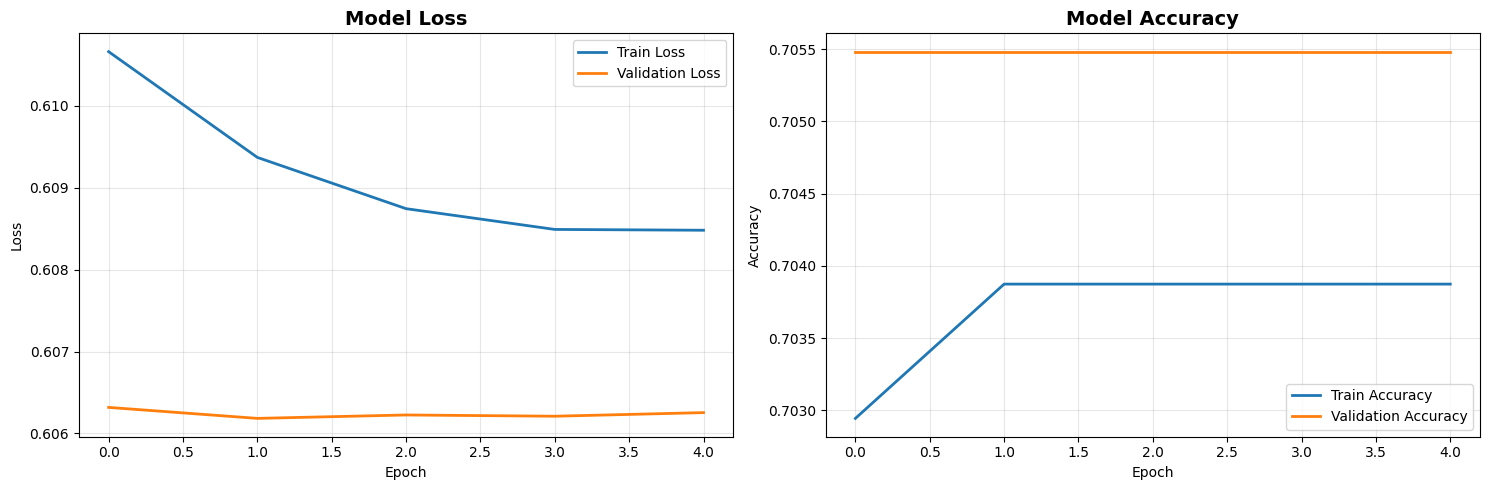

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot (for classification)
if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:  # regression
    axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Evaluate on Test Set

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = model.evaluate(test_padded, test_y, verbose=1)

if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    print(f"\nTest Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
else:
    print(f"\nTest Loss (MSE): {test_results[0]:.4f}")
    print(f"Test MAE: {test_results[1]:.4f}")

Evaluating on test set...
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 165s 114ms/step - accuracy: 0.6982 - loss: 0.6124

Test Loss: 0.6110
Test Accuracy: 0.6999


In [ ]:
# Get predictions
print("\nGenerating predictions...")
test_predictions = model.predict(test_padded, verbose=1)

if CLASSIFICATION_TYPE == 'binary':
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()
elif CLASSIFICATION_TYPE == 'multiclass':
    test_pred_classes = np.argmax(test_predictions, axis=1)
else:  # regression
    test_pred_classes = test_predictions.flatten()

print("✓ Predictions generated")


Generating predictions...
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 161s 111ms/step
✓ Predictions generated


## 12. Detailed Classification Report


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     13839
           1     0.6999    1.0000    0.8234     32269

    accuracy                         0.6999     46108
   macro avg     0.3499    0.5000    0.4117     46108
weighted avg     0.4898    0.6999    0.5763     46108



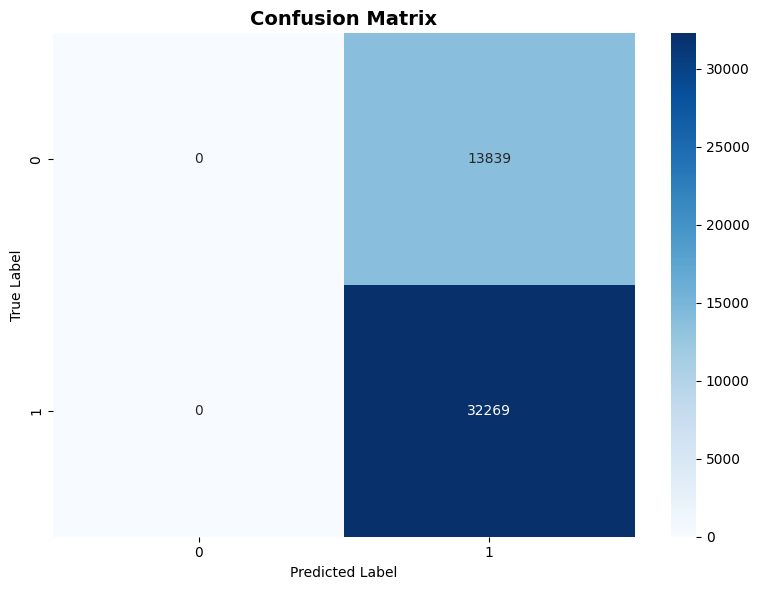


Per-Class Metrics:
   Precision  Recall  F1-Score  Support
0   0.000000     0.0   0.00000    13839
1   0.699857     1.0   0.82343    32269


In [ ]:
if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    # Classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(test_y, test_pred_classes, digits=4))

    # Confusion matrix
    cm = confusion_matrix(test_y, test_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(test_y, test_pred_classes)

    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    print("\nPer-Class Metrics:")
    print(metrics_df.to_string())
else:
    # Regression metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    mse = mean_squared_error(test_y, test_pred_classes)
    mae = mean_absolute_error(test_y, test_pred_classes)
    r2 = r2_score(test_y, test_pred_classes)

    print("\n" + "="*50)
    print("REGRESSION METRICS")
    print("="*50)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(test_y, test_pred_classes, alpha=0.5)
    plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--', lw=2)
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title('Predicted vs True Ratings')
    plt.tight_layout()
    plt.show()

## 13. Save Results

In [ ]:
# Compile results dictionary
results = {
    'model': 'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM',
    'embedding': f'{EMBEDDING_TYPE}_{EMBEDDING_CONFIG}',
    'embedding_dim': EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'vocab_size': len(word_to_idx),
    'preprocessing': PREPROCESSING_CONFIG,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'classification_type': CLASSIFICATION_TYPE,
}

if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    results['test_accuracy'] = float(test_results[1])
    results['test_loss'] = float(test_results[0])

    # Add precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(test_y, test_pred_classes, average='weighted')
    results['precision'] = float(precision)
    results['recall'] = float(recall)
    results['f1_score'] = float(f1)
else:
    results['test_mse'] = float(test_results[0])
    results['test_mae'] = float(test_results[1])
    results['r2_score'] = float(r2_score(test_y, test_pred_classes))

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
for key, value in results.items():
    print(f"{key}: {value}")

# Save results to JSON
import json
with open('lstm_glove_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Results saved to 'lstm_glove_results.json'")


FINAL RESULTS SUMMARY
model: LSTM
embedding: glove_medium
embedding_dim: 200
lstm_units: 64
max_sequence_length: 100
vocab_size: 10001
preprocessing: moderate
batch_size: 128
epochs_trained: 5
classification_type: binary
test_accuracy: 0.6998568773269653
test_loss: 0.6109901070594788
precision: 0.48979962142661665
recall: 0.6998568578120934
f1_score: 0.5762833725388428

✓ Results saved to 'lstm_glove_results.json'


## 14. Model Summary and Comparison

In [ ]:
print("\n" + "="*70)
print("LSTM + GLOVE - EXPERIMENT COMPLETE")
print("="*70)
print(f"\nModel: {'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM'}")
print(f"Embedding: GloVe (200-dim)")
print(f"Total Parameters: {model.count_params():,}")

if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    print(f"\nFinal Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"F1-Score: {results['f1_score']:.4f}")
else:
    print(f"\nFinal Test MAE: {results['test_mae']:.4f}")
    print(f"R² Score: {results['r2_score']:.4f}")



LSTM + GLOVE - EXPERIMENT COMPLETE

Model: LSTM
Embedding: GloVe (200-dim)
Total Parameters: 2,082,633

Final Test Accuracy: 0.6999
F1-Score: 0.5763
